### Laboratory of Computational Physics Mod. B 
#### Students

- Marchetti Andrea - 2089216 - andrea.marchetti.5@studenti.unipd.it
- Menti Luca  - 2069534 - luca.menti@studenti.unipd.it
- Merlin Giovanni - 2091186 - giovanni.merlin@studenti.unipd.it
- Saretto Alberto - 2063139 - alberto.saretto.1@studenti.unipd.it


### Exercise 3 (Data visualization and clustering)

In [21]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 15

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [22]:
fname,fnamey="x_3d.dat","y_3d.dat"
data=np.loadtxt(fname, delimiter='\t')
y=np.loadtxt(fnamey,dtype=int)
N=len(data)
D=len(data[0])
print("N=",N,"  D=",D)
x=data

N= 600   D= 3


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

In [23]:
def dist(x,i,j):
    return np.linalg.norm(x[i]-x[j])

print(dist(x,13,1))
mdist = np.zeros(N)
for i in range(N):
    dm = 1e100
    for j in range(N):
        if i!=j:
            dij = dist(x,i,j);
            if dij<dm:
                dm = dij
    mdist[i] = dm
mean_min_dist = mdist.mean()
print("mean minimum distance between points: ",mean_min_dist)

569.5269005085432
mean minimum distance between points:  23.321029500210262


## t-SNE visualization, for true labels

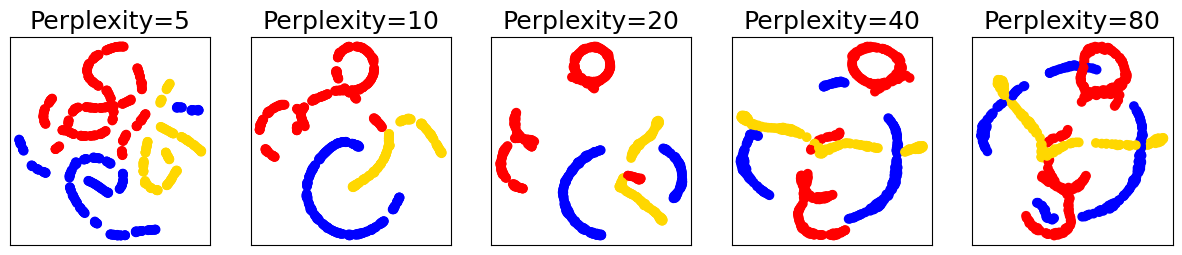

In [24]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexities = [5, 10, 20, 40, 80]
Np = len(perplexities)
mycmap = ListedColormap(["blue","red","gold" ])

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=10, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

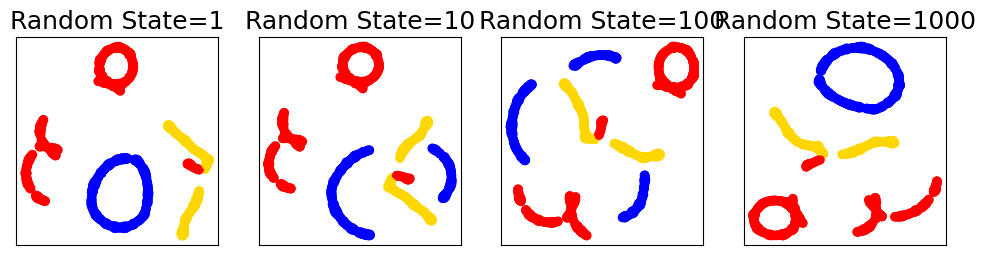

In [25]:
np.random.seed(0)
n_samples = N
n_components = 2 
perplexity = 20
mycmap = ListedColormap(["blue","red","gold" ])
random_states = [1, 10, 100, 1000]
Np = len(random_states)

(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

X_all = [None]
for i, random_state in enumerate(random_states):
    ax = subplots[i]

    t0 = time()
    tsne = manifold.TSNE(n_components=n_components, init='random',
                         random_state=random_state, perplexity=perplexity)
    Y = tsne.fit_transform(data)
    t1 = time()
    ax.set_title("Random State=%d" % random_states[i])
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

- Comments on the result. We note how the cluster structure is preserved by varying the random state variable. However, such clusters appear to be shifted and rotated depending on the value of the random state. Indeed, these random numbers are only used to initialise the parameters and therefore do not determine a qualitative variation of the results but only affect their visualisation.

## DBSCAN: find labels by applying clustering

IndexError: index 4 is out of bounds for axis 0 with size 4

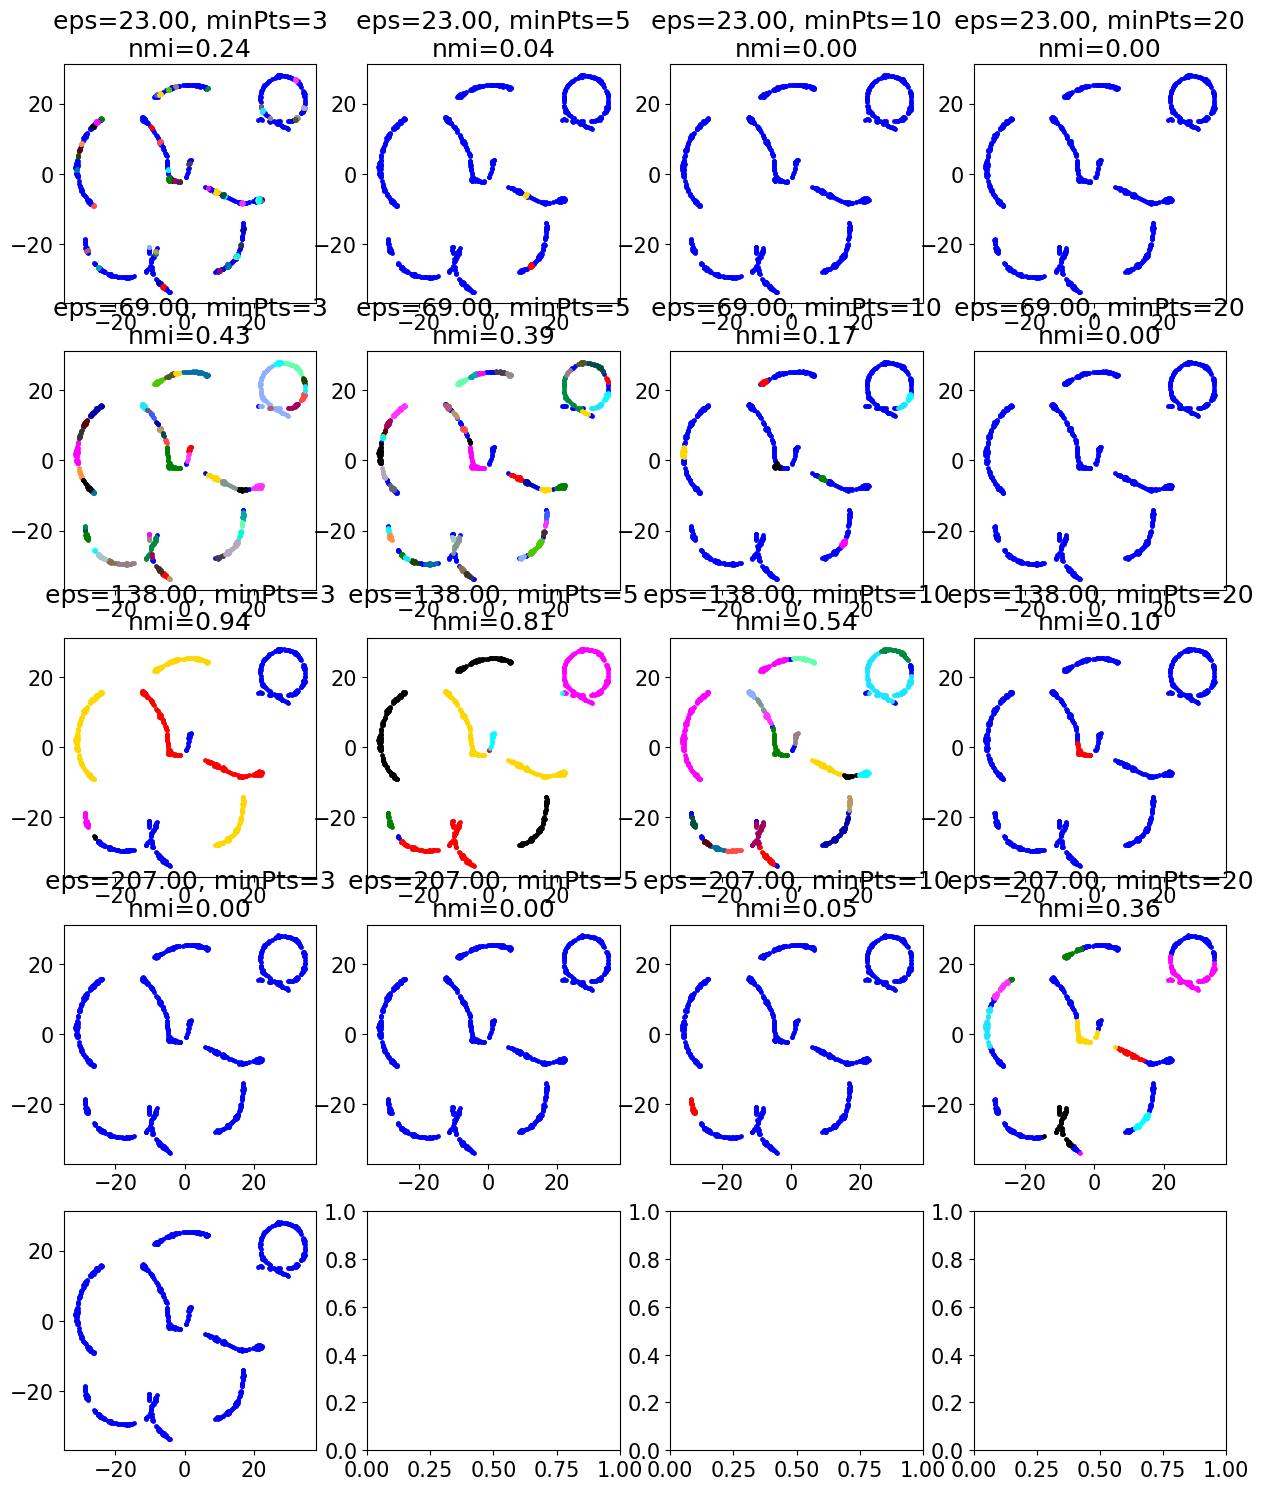

In [26]:
from sklearn.cluster import DBSCAN
#from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
from collections import OrderedDict
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)
n_true_center=3
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X2D = X_all[3] # best visualization above
X = data
y_true = y
nim_map=np.zeros((4,4))
#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)
eps_range = [r,3*r,6*r,9*r,12*r]
min_sample_range = [3,5,10,20]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,18))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X2D,y_hat,ax[i,j])
        nmi=NMI(y_hat, y_true)
        nim_map[i,j]=nmi
        ax[i,j].set_title('eps=%.2f, minPts=%i\nnmi=%.2f'%(eps,min_samples,nmi))
plt.tight_layout(h_pad=0.5)
plt.show()


In [ ]:
sns.heatmap(nmi_heat, annot=False,cbar=True)

In [19]:
#more eps
arr_eps=np.linspace(1, 12, 50)
eps_range = [i*r for i in arr_eps]
y_var=[]
nmi_heat=[]
#more nps
nmi_heat = np.zeros((50,50))
min_samples_range=np.linspace(1, 20, 50)
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        nmi = NMI(y_hat, y_true)
        y_var.append(y_hat)
        nmi_heat[i,j] = nmi

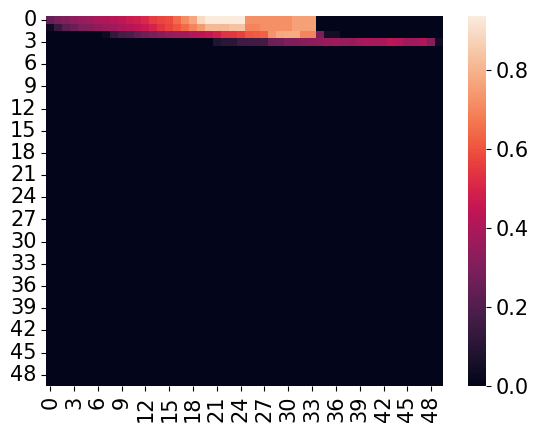

In [18]:
import seaborn as sns

#Plot heatmap
nmi_heat.shape
sns.heatmap(nmi_heat, annot=False,cbar=True)
#plt.xlabel("min_samples")
#plt.ylabel("eps")



#plt.xticks([0, 10, 20, 30, 40, 50], ['0', '4', '8', '12', '16', '20'])
#plt.yticks([0, 10, 20, 30, 40], ['0', '60', '120', '180',"240"])



In [16]:
nmi_heat

array([[0.24140513, 0.03996728, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28434116, 0.13953618, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.30979033, 0.22453929, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [20]:
print(eps_range)

[23.0, 28.16326530612245, 33.3265306122449, 38.48979591836735, 43.6530612244898, 48.81632653061224, 53.9795918367347, 59.14285714285714, 64.3061224489796, 69.46938775510203, 74.63265306122449, 79.79591836734693, 84.95918367346938, 90.12244897959184, 95.28571428571428, 100.44897959183673, 105.61224489795919, 110.77551020408163, 115.93877551020407, 121.10204081632654, 126.26530612244898, 131.42857142857144, 136.59183673469386, 141.75510204081633, 146.91836734693877, 152.08163265306123, 157.24489795918367, 162.40816326530614, 167.57142857142856, 172.73469387755102, 177.89795918367346, 183.06122448979593, 188.22448979591837, 193.3877551020408, 198.55102040816325, 203.71428571428572, 208.87755102040813, 214.0408163265306, 219.20408163265307, 224.3673469387755, 229.53061224489795, 234.6938775510204, 239.85714285714286, 245.02040816326533, 250.18367346938774, 255.3469387755102, 260.51020408163265, 265.6734693877551, 270.83673469387753, 276.0]


### Comments on the result. 
We can notice how the provided value for NMI is higher for low values of the _minPTs_. Moreover we notice how the highest value for NMI is reached considering about 100 _eps_ and the minumum values for _minPTs_ 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f9a84204-1436-45b1-b380-53fb9847bfaa' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>